In [1]:
#!/usr/bin/python

import numpy as np
import torch
import cvxopt as cvx
from util import *
import matplotlib.pyplot as plt
from matplotlib import cm
import gymnasium as gym
from kan import *

## Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


## initial dataset (always starts in an area where the norm of the state vector is less than 2)
train_input, train_label = generate_dictionary(n_samples=1000, random_state=2024)
test_input, test_label = generate_dictionary(n_samples=1000, random_state=2025)

dataset = {}
dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

## output sizes of datasets
print(f"train_input: {dataset['train_input'].shape}")
print(f"test_input: {dataset['test_input'].shape}")
print(f"train_label: {dataset['train_label'].shape}")
print(f"test_label: {dataset['test_label'].shape}")


# ## Define gym Inverted Pendulum env
env = InvertedPendulum(a=0.25, b=0.5, Kp=0.6, Kd=0.6, render_mode='human')

## Define proposed ground truth CBF
a = 0.25
b = 0.5
CBF = lambda x: 1 - ((x[0]**2)/a**2) - ((x[1]**2)/b**2) - ((x[0]*x[1])/(a*b))

env.set_CBF(CBF)

## Define alpha
gamma = 1
alpha = lambda h, u_ref: gamma*h
env.set_alpha(alpha)

## test basic controller with CBF

## simulation parameters
num_steps = 300
CBF_states = []
CBF_actions = []
CBF_actual_cbf_value = []

# ## simulation loop
# state = env.reset() # Always in CW+ reference frame
# for step in range(num_steps):
#     action = env.ref_controller(state)
#     #action = np.random.uniform(-10.0, 10.0)
#     next_state, _, _, done, _ = env.step(action)
#     CBF_states.append(state)
#     CBF_actions.append(action)
#     CBF_actual_cbf_value.append(env.h(state, action))
#     state = next_state 
#     if done:
#         break
#     #env.render()
#     if step == num_steps - 1:
#         print("Inverted Pendulum did not fall in {} steps".format(num_steps))

# env.close()

# Convert lists to numpy arrays for easier manipulation
CBF_states = np.array(CBF_states)
CBF_actions = np.array(CBF_actions)
CBF_actual_cbf_value = np.array(CBF_actual_cbf_value)

# ----------------------------------------------
## Initialize KAN
env = InvertedPendulum(a=0.25, b=0.5, Kp=0.6, Kd=0.6, render_mode='human', mode = 'KAN')
#env.set_CBF(CBF)

# ## Define alpha
# gamma = 1
# alpha = lambda h, u_ref: gamma*h
env.set_alpha(alpha)



## Create dataset [this will generate training points, but does not show the model the actual CBF]
## Define KAN CBF
a = 0.25
b = 0.5
kan_CBF = lambda x: 1 - ((x[:,[0]]**2)/a**2) - ((x[:,[1]]**2)/b**2) - ((x[:,[0]]*x[:,[1]])/(a*b))
env.set_CBF(CBF)

## Train KAN (start from low grid, refine)
grids = [3,5,10,20,50]

train_losses = []
test_losses = []
data_range_theta = torch.linspace(-np.pi, np.pi, steps = 1001)[:,None]
data_range_theta_dot = torch.linspace(-8.0, 8.0, steps = 1001)[:,None]
data_range = torch.cat((data_range_theta, data_range_theta_dot), dim=1).to(device)

for grid in grids:
    if grid == 3:
        kanModel = kanNetwork(environment=env, width=[2, 5, 5, 5, 1], grid=grid, k=3, device=device, dataset = dataset)
        kanModel.update_grid_from_samples(data_range)
        lr = 1e-2
    else:
        kanModel.refine(grid)
        kanModel.update_grid_from_samples(data_range)
        # if grid == 20:
        #     lr = 5e-4
        if grid >= 10:
            lr = 1e-3

    results = kanModel.results(kanModel.dataset, opt='Adam', steps=200, lr=lr)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

Device: cpu
train_input: torch.Size([2000, 2])
test_input: torch.Size([2000, 2])
train_label: torch.Size([2000, 1])
test_label: torch.Size([2000, 1])
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]/Users/nmiguel/pykan/CBF_src/InvertedPendulumClassification/util.py:405: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ind_desc_loss = LfB + LgB*torch.tensor(self.environment.ref_controller(x), dtype=torch.float32) + prediction[jter]
/Users/nmiguel/pykan/CBF_src/InvertedPendulumClassification/util.py:432: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_safe_mean = torch.relu(torch.tensor(torch.mean(torch.tensor(loss_safe, dtype=torch.float32))))
/Users/nmiguel/pykan/CBF_src/InvertedPendulumClassification/util.py:433: UserWarning: To copy construct from a tensor, it is recommended to use

KeyboardInterrupt: 

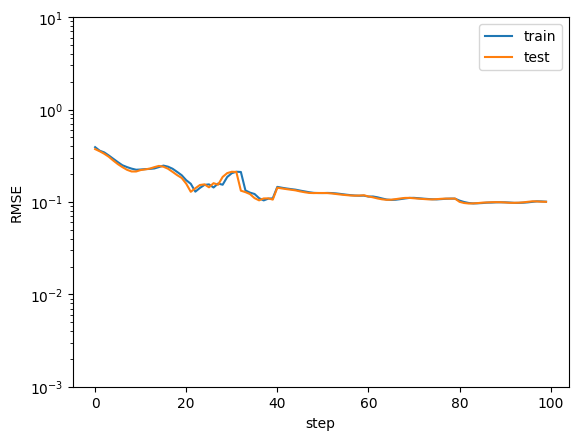

In [2]:
## Plot
plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')
plt.ylim([1e-3, 1e+1])
plt.show()

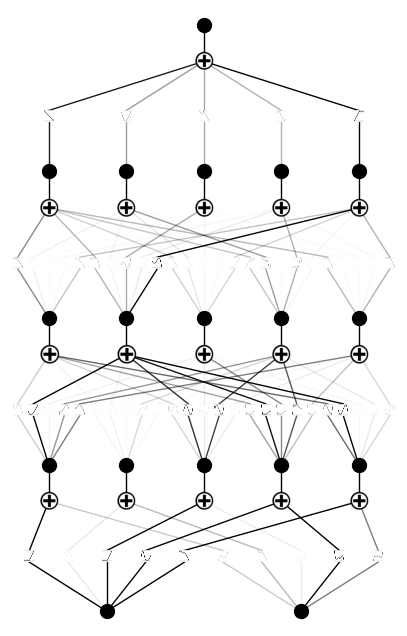

In [3]:
kanModel.plot()

/var/folders/x4/9hvgz2l93r9ft0_yp6wwfdv00000gq/T/ipykernel_8333/2859010511.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  surf = ax.contourf(X, Y, kan_values, cmap=cm.coolwarm, linewidth=0, antialiased=False)


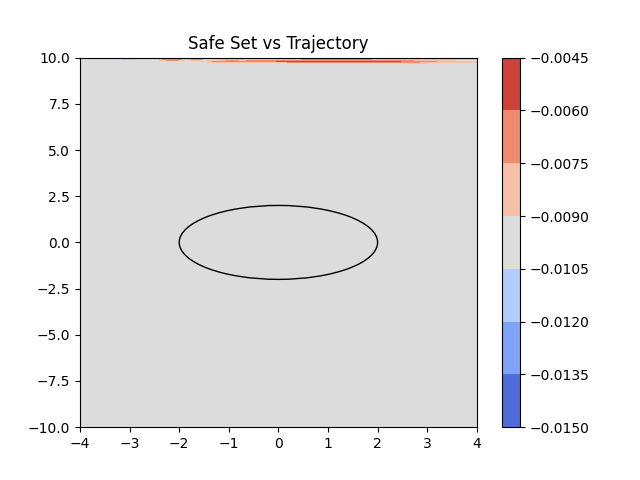

In [4]:
%matplotlib ipympl
## Plot safe set vs trajectory
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig, ax = plt.subplots()
## Create 2D grid of states
x = np.linspace(-4.0, 4.0, 200)
y = np.linspace(-10.0, 10.0, 200)
X, Y = np.meshgrid(x, y)
states_grid = np.column_stack((X.flatten(), Y.flatten()))

## Calculate CBF values for each state in the grid
cbf_values = np.linalg.norm(states_grid, axis=1)


# for pair in states_grid:
#     #h_temp = env.h(pair, 0)
#     h_temp = np.linalg.norm(pair)
#     cbf_values.append(h_temp)
# cbf_values = np.array(cbf_values)

states_grid_torch = torch.tensor(states_grid, dtype=torch.float32).to(device)
kan_values = kanModel(states_grid_torch).detach().cpu().numpy()
## sort out all states that are not in the safe set
kan_states_grid = states_grid[np.where(kan_values > 0.0)]

kan_values = kan_values.reshape(X.shape)

kan_values = np.clip(kan_values, -5.0, 5.0)

#ax.contourf(X, Y, cbf_values.reshape(X.shape), cmap='Blues')
surf = ax.contourf(X, Y, kan_values, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Also plot circle
circle = plt.Circle((0, 0), 2, color='black', fill=False)
ax.add_patch(circle)

#plt.scatter(kan_states_grid[:, 0], kan_states_grid[:, 1], marker='.', c='red', label='KAN Safe Set', alpha=0.3)
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-10.0, 10.0)
#ax.set_zlim(-0.1, 0.05)
fig.colorbar(surf)
plt.title('Safe Set vs Trajectory')
plt.show()

In [5]:
x = torch.tensor([[-0.1, 0.0]], dtype=torch.float32, requires_grad=True).to(device)
pred = kanModel(x)
predicted_label = 'safe' if pred < 0.0 else 'unsafe'
actual_label = 'safe' if np.linalg.norm(x.cpu().detach().numpy()) < 2.0 else 'unsafe'
dx = torch.autograd.grad(pred, x, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
dx = dx.detach().cpu().numpy()
LfB = dx @ kanModel.environment.f(x.detach().numpy().flatten())
LgB = dx @ kanModel.environment.g_dyn()
lhs = LfB.item() + LgB.item() * kanModel.environment.ref_controller(x.detach().numpy().flatten()) + pred.item()
descent_satisfied = 'True' if lhs < 0.0 else 'False'


print(f"Input is {str(x.detach().numpy())}.\nprediction is {str(pred.item())}\npredicted label is {predicted_label}\nactual label is {actual_label}\n")
print(f"Gradient is {dx}, \n")
print(f"LHS is {lhs}, descent satisfied: {descent_satisfied}")


Input is [[-0.1  0. ]].
prediction is 0.09625974297523499
predicted label is unsafe
actual label is safe

Gradient is [[0.0425984  0.00911344]], 

LHS is 0.09680654940078864, descent satisfied: False


/Users/nmiguel/pykan/kan/MultKAN.py:799: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/Users/nmiguel/pykan/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/Users/nmiguel/pykan/kan/MultKAN.py:810: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1

In [8]:
lib = ['x', 'x^2', 'x^3', 'x^4', 'x^5', '1/x', '1/x^2', '1/x^3', '1/x^4', '1/x^5', 'sqrt', 'x^0.5', 'x^1.5', '1/sqrt(x)', '1/x^0.5', 'exp', 'log', 'abs', 'sin', 'cos', 'tan', 'tanh', 'sgn', 'arcsin', 'arccos', 'arctan', 'arctanh', '0', 'gaussian']
kanModel.auto_symbolic(lib=lib)
formula = kanModel.symbolic_formula()[0][0]
ex_round(formula, 5)

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,0,4) with 0, r2=0.0, c=0
fixing (0,0,5) with 0, r2=0.0, c=0
fixing (0,0,6) with 0, r2=0.0, c=0
fixing (0,0,7) with 0, r2=0.0, c=0
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,1,1) with 0, r2=0.0, c=0
fixing (0,1,2) with 0, r2=0.0, c=0
fixing (0,1,3) with 0, r2=0.0, c=0
fixing (0,1,4) with 0, r2=0.0, c=0
fixing (0,1,5) with 0, r2=0.0, c=0
fixing (0,1,6) with 0, r2=0.0, c=0
fixing (0,1,7) with 0, r2=0.0, c=0
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,0,1) with 0, r2=0.0, c=0
fixing (1,0,2) with 0, r2=0.0, c=0
fixing (1,0,3) with 0, r2=0.0, c=0
fixing (1,0,4) with 0, r2=0.0, c=0
fixing (1,0,5) with 0, r2=0.0, c=0
fixing (1,0,6) with 0, r2=0.0, c=0
fixing (1,0,7) with 0, r2=0.0, c=0
fixing (1,1,0) with 0, r2=0.0, c=0
fixing (1,1,1) with 0, r2=0.0, c=0
fixing (1,1,2) with 0, r2=0.0, c=0
fixing (1,1,3) with 0, r2=0.0, c=0
fixing (1,1,4) with 

0.07179

In [8]:
X = train_input.reshape(-1,2)

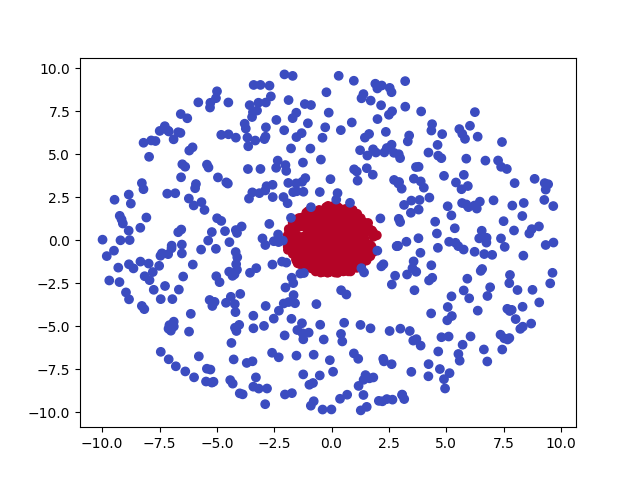

In [9]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=train_label, cmap='coolwarm')
plt.show()